# requirements

In [1]:
import pandas as pd
import os
import scipy.io as sio
import numpy as np
import random
from random import randrange, shuffle, random, randint
import re

import math
import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt

# Load data and tokenize

In [2]:
class PabloDNADataset:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, sep="\t", encoding="unicode_escape")

    def clean_nan(self, col_names, replace_orig=False):
        clean_df = self.df.dropna(subset=col_names)
        clean_df = clean_df.reset_index(drop=True)
        if replace_orig:
            self.df = clean_df
        return clean_df
    
    def change_RXY2N(self, col_names, replace_orig=False):
      full_pattern = re.compile('[^ACGTN\-]') 
      self.df[col_names] = self.df[col_names].apply(lambda x: re.sub(full_pattern, 'N', x))
      # if replace_orig:
      #   self.df[col_names] = clean_nucleotides
      # return clean_str_df


    def generate_mini_sample(self, dataframe=None, bin_count=20, output_path="mini_sample.tsv"):
        if dataframe is None:
            dataframe = self.df
        bins = list(dataframe['bin_uri'].unique())
        rd1 = random.sample(range(0, len(bins)), bin_count)
        bins = [bins[i] for i in rd1]
        mini_df = dataframe.loc[dataframe['bin_uri'].isin(bins)]
        mini_df = mini_df.reset_index(drop=True)
        # mini_df = dataframe.iloc[0:sample_count]
        # mini_df = dataframe.take(np.random.permutation(len(dataframe))[:sample_count])
        mini_df.to_csv(output_path, sep="\t")

    def get_info(self, dataframe=None):
        if dataframe is None:
            dataframe = self.df
        print("Total data: ", len(dataframe))
        print("Number of bin clusters: ", len(dataframe['bin_uri'].unique()))



In [3]:
def tokenizer(dna_sentence, k_mer_dict, k_mer_length, stride=1):
    tokens = []
    for i in range(0, len(dna_sentence) - k_mer_length + 1, stride):
        k_mer = dna_sentence[i:i + k_mer_length]
        tokens.append(k_mer_dict[k_mer])
    return tokens


class SampleDNAData(Dataset):
    """Barcode Dataset"""

    @staticmethod
    def get_all_kmers(k_mer_length, alphabet=None) -> list:
        """
        :rtype: object
        """
        def base_convert(num, base, length):
            result = []
            while num > 0:
                result.insert(0, num % base)
                num = num // base
            while len(result) < length:
                result.insert(0, 0)
            return result

        if alphabet is None:
            alphabet = ["A", "C", "G", "T", "-", "N"]
        k_mer_counts = len(alphabet) ** k_mer_length
        all_k_mers_list = []
        for i in range(k_mer_counts):
            code = base_convert(num=i, base=len(alphabet), length=k_mer_length)
            k_mer = ""
            for j in range(k_mer_length):
                k_mer += alphabet[code[j]]
            all_k_mers_list.append(k_mer)

        return all_k_mers_list

    
    def __init__(self, file_path, k_mer=4, data_count=None, max_mask_count=5, max_len=256):
        self.k_mer = k_mer
        pablo_dataset = PabloDNADataset(file_path)
        if data_count is None:
            data_count = len(pablo_dataset.df)
        # for removing X,R,Y letters from data
        # pablo_dataset.change_RXY2N("nucleotides")
        self.dna_nucleotides = list(pablo_dataset.df["nucleotides"].values)
        word_list = SampleDNAData.get_all_kmers(self.k_mer)

        number_dict = dict()
        word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
        for i, w in enumerate(word_list):
            word_dict[w] = i + 4
            number_dict = {i: w for i, w in enumerate(word_dict)}

        self.word_dict = word_dict
        self.number_dict = number_dict

        self.vocab_size = len(word_dict)
        self.max_len = max_len

        self.batch = []
        positive = negative = 0
        while positive != data_count / 2 or negative != data_count / 2:
            is_positive = randrange(0, 2)

            tokens_a_index, tokens_b_index = 0, 0
            while tokens_a_index == tokens_b_index:
                tokens_a_index, tokens_b_index = randrange(len(self.dna_nucleotides)), randrange(
                    len(self.dna_nucleotides))

            if is_positive:
                dna_a = self.dna_nucleotides[tokens_a_index]
                dna_b = dna_a
            else:
                dna_a = self.dna_nucleotides[tokens_a_index]
                dna_b = self.dna_nucleotides[tokens_b_index]

            rand_len = randrange(128, 256)

            dna_a = dna_a[0:len(dna_a) // 2][0:rand_len]  # max_len//2 - 3]
            dna_b = dna_b[len(dna_b) // 2:][0:rand_len]  # max_len//2 - 3]
            tokens_a = tokenizer(dna_a, word_dict, k_mer, stride=1)
            tokens_b = tokenizer(dna_b, word_dict, k_mer, stride=1)
            input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
            segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

            # MASK LM
            n_pred = min(max_mask_count, max(1, int(round(len(input_ids) * 0.15)))) // self.k_mer  # 15 % of tokens in one sentence
            cand_masked_pos = [i for i, token in enumerate(input_ids)
                               if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]

            # remove N and gaps from cand_masked_pos
            cand_masked_pos_copy = cand_masked_pos.copy()
            for position in cand_masked_pos_copy:
                remove_flag = False
                for s in range(self.k_mer):
                    if position + s < len(input_ids):
                        key = self.number_dict[input_ids[position + s]]
                        if ("N" in key) or ("-" in key):
                            remove_flag = True
                            break
                if remove_flag:
                    cand_masked_pos.remove(position)

            shuffle(cand_masked_pos)

            # if the position remains is less than 15%, mask them all
            if len(cand_masked_pos) < n_pred:
                n_pred = len(cand_masked_pos)

            masked_tokens, masked_pos = [], []
            for pos in cand_masked_pos[:n_pred]:
                for s in range(self.k_mer):
                    if pos + s < len(input_ids):
                        masked_pos.append(pos + s)
                        masked_tokens.append(input_ids[pos + s])
                        input_ids[pos + s] = word_dict['[MASK]']  # make mask

            # Zero Paddings
            n_pad = max_len - len(input_ids)
            input_ids.extend([0] * n_pad)
            segment_ids.extend([0] * n_pad)

            # Zero Padding (100% - 15%) tokens
            if max_mask_count > len(masked_pos):
                n_pad = max_mask_count - len(masked_pos)
                masked_tokens.extend([0] * n_pad)
                masked_pos.extend([0] * n_pad)

            if is_positive and positive < data_count / 2:
                self.batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True])  # IsNext
                positive += 1
            elif not is_positive and negative < data_count / 2:
                self.batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False])  # NotNext
                negative += 1

    def __len__(self):
        return len(self.batch)

    def __getitem__(self, idx):
        ids = torch.Tensor(self.batch[idx][0])
        seg = torch.Tensor(self.batch[idx][1])
        msk_tok = torch.Tensor(self.batch[idx][2])
        msk_pos = torch.Tensor(self.batch[idx][3])
        label = torch.Tensor([self.batch[idx][4]])

        ids, seg, msk_pos = ids.type(torch.IntTensor), seg.type(torch.IntTensor), msk_pos.type(torch.int64)

        msk_tok = msk_tok.type(torch.LongTensor)
        label = label.type(torch.LongTensor)

        return ids, seg, msk_pos, msk_tok, label


# Model

In [4]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(int(vocab_size), int(d_model))  # token embedding
        self.pos_embed = nn.Embedding(int(maxlen), int(d_model))  # position embedding
        self.seg_embed = nn.Embedding(int(n_segments), int(d_model))  # segment(token type) embedding
        self.norm = nn.LayerNorm(int(d_model))
        self.device = device

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    pad_attn_mask = pad_attn_mask.to(device)
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k


class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_k)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)  # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs)  # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)

        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.d_model = d_model

        self.linear = nn.Linear(self.n_heads * self.d_v, self.d_model)

        self.layernorm = nn.LayerNorm(self.d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)  # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)  # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)

        return self.layernorm(output + residual), attn  # output: [batch_size x len_q x d_model]


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.l1 = nn.Linear(d_model, d_ff)
        self.l2 = nn.Linear(d_ff, d_model)

        self.relu = GELU()
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs
        output = self.l1(inputs)
        output = self.relu(output)
        output = self.l2(output)
        return self.layer_norm(output + residual)


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        self.d_k = d_k
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(
            self.d_k)  # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9)  # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn


class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments, n_layers, d_k, d_v, n_heads, device):
        super(BERT, self).__init__()
        self.embedding = Embedding(vocab_size, d_model, maxlen, n_segments, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_k, d_v, n_heads) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = GELU()
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device=device
        self.to(self.device)

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            # embedding layer
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # classifier pos/neg (it will be decided by first token(CLS))
        h_pooled = self.activ1(self.fc(output[:, 0]))  # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled)  # [batch_size, 2]

        # classifier mask
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))  # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos)  # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias  # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf, output

# Train


Mount your drive to access the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# File path of the input
# input_path = "/content/drive/MyDrive/BIOSCAN/full_training.tsv"
# input_path = "/content/drive/MyDrive/BIOSCAN/medium_training.tsv"
input_path = "/content/drive/MyDrive/BIOSCAN/small_training.tsv"


# dataloader to get a batch of data
dataset = SampleDNAData(file_path=input_path, k_mer=4, data_count=256, max_mask_count=80, max_len=512)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# define the model
# DNABert configuration
config = {
    "d_model": 768,
    "n_heads": 12,
    "n_layers": 12 

}
# # first config
# config = {
#     "d_model": 16,
#     "n_heads": 2,
#     "n_layers": 5 

# }
model = BERT(dataset.vocab_size, config["d_model"], dataset.max_len, 2, config["n_layers"], 32, 32, config["n_heads"], device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
saving_path = "/content/drive/MyDrive/BIOSCAN/model_checkpoints/"
epoch_loss_list = []
training_epoch = 1000
continue_epoch = 0

''' 
If you lost your connection and want to continue the training process, 
uncomment this part, load your last model, optimizer, and loss, 
choose the epoch you 
want to continue from
'''
# continue_epoch = 100
# model.load_state_dict(torch.load(saving_path + f'model_{continue_epoch}.pth'))
# optimizer.load_state_dict(torch.load(saving_path + f"optimizer_{continue_epoch}.pth"))

# a_file = open(saving_path + "loss.pkl", "rb")
# epoch_loss_list = pickle.load(a_file)



' \nIf you lost your connection and want to continue the training process, \nuncomment this part, load your last model, optimizer, and loss, \nchoose the epoch you \nwant to continue from\n'

In [9]:
# strat training
for epoch in range(continue_epoch, training_epoch + 1):
    epoch_loss = 0
    for ids, seg, msk_pos, masked_tokens, is_pos in dataloader:
        ids = ids.to(device)
        seg = seg.to(device)
        msk_pos = msk_pos.to(device)
        masked_tokens = masked_tokens.to(device)
        is_pos = is_pos.to(device)

        optimizer.zero_grad()
        logits_lm, logits_clsf, outputs= model(ids, seg, msk_pos)

        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens)  # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_clsf = criterion(logits_clsf, torch.squeeze(is_pos))  # for sentence classification
        loss = loss_lm + loss_clsf

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    epoch_loss_list.append(epoch_loss)

    print(f"epoch {epoch}: Loss is {epoch_loss}")

    # every 50 epoch save the checkpoints and save the loss in a list
    if epoch % 50 == 0:
        torch.save(model.state_dict(), saving_path + "model_" + str(epoch) +'.pth')
        torch.save(optimizer.state_dict(), saving_path + "optimizer_" + str(epoch) +'.pth')

        a_file = open(saving_path + "loss.pkl", "wb")
        pickle.dump(epoch_loss_list, a_file)
        a_file.close()


epoch 0: Loss is 2358.167432785034
epoch 1: Loss is 528.3459033966064
epoch 2: Loss is 393.48581981658936
epoch 3: Loss is 360.1351442337036
epoch 4: Loss is 358.3264570236206
epoch 5: Loss is 369.4758577346802
epoch 6: Loss is 341.71941471099854
epoch 7: Loss is 345.9011182785034
epoch 8: Loss is 341.4824810028076
epoch 9: Loss is 338.59256076812744
epoch 10: Loss is 336.25152254104614
epoch 11: Loss is 334.93188428878784
epoch 12: Loss is 333.64481019973755
epoch 13: Loss is 332.3218665122986
epoch 14: Loss is 331.03067445755005
epoch 15: Loss is 329.87801694869995
epoch 16: Loss is 329.0447030067444
epoch 17: Loss is 328.59162616729736
epoch 18: Loss is 328.3054504394531
epoch 19: Loss is 328.2332649230957
epoch 20: Loss is 328.1945013999939
epoch 21: Loss is 328.5982394218445
epoch 22: Loss is 328.5405373573303
epoch 23: Loss is 328.31352186203003
epoch 24: Loss is 327.8445954322815
epoch 25: Loss is 327.6662220954895
epoch 26: Loss is 327.2606167793274
epoch 27: Loss is 327.060087

## Plot the loss after training

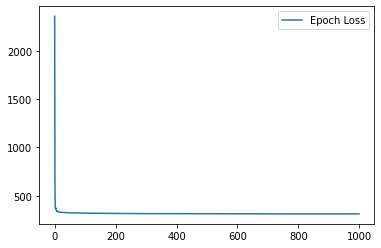

In [10]:
plt.plot(epoch_loss_list, label ="Epoch Loss")
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/BIOSCAN/model_checkpoints_new/loss_per_epoch.png')
plt.show()